# News Classification with Machine Learning

This project demonstrates an application of natural language processing (NLP) to classify news stories.

1. [Setup](#Setup) -
2. [Feature Extration](#Feature-Extraction)

## Load and setup data

Load data from the CSV in the input directory.
Data is structured as individual JSON lines with the following properties:

| Column Name        | Type       | Description                    |
|:-------------------|:-----------|:-------------------------------|
| category           | category   | One of 42 categories           |
| headline           | string     | Story headline                 |
| short_description  | string     | Brief description of the story |
| link               | string     | URL to story                   |
| authors            | string     | Name of article authors        |
| date               | YYYY-MM-DD | Date article was published     |

### Data source
    Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
    Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).
    https://rishabhmisra.github.io/publications/

In [1377]:
import pandas as pd
from babel.messages.frontend import SetupError

df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)
df['category'] = df['category'].astype('category') # Set category column as panda's category type to ensure efficient processing

display(df.head())

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [1378]:
from sklearn.model_selection import train_test_split

x = df['headline'] + ' ' + df['short_description'] # x, input, independent variable, is all text headline + short_description
y = df[['category']] # y, output, dependent variable, is dataframe with only category column

# Split data into train (80%) and test (remaining 20%). Use stratify to ensure even split of categories
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y['category'], random_state=5)

In [1379]:
# Group training data by category
articles_by_category = (
    x_train
        .groupby(y_train['category'], observed=True)
        .apply(lambda article: ' '.join(article.astype(str))) # all_articles column contains text from all articles for the category
        .reset_index(name='all_articles')
)

## Feature Extraction

In [1381]:
%%capture
import nltk
import subprocess
import sys

'''
Download data needed for tokenization
'''
try:
    nltk.data.find('wordnet') # Attempt to locate wordnet
except LookupError:
    # When wordnet data is not found, download to working directory and unzip.
    nltk.download('wordnet', download_dir='../working/', quiet=True)
    if sys.platform.startswith('linux'): # Unzip is necessary on Kaggle but this will work in any linux based environment
        command = "unzip ../working/corpora/wordnet.zip -d ../working/corpora"
        subprocess.run(command.split())
        nltk.data.path.append('../working/')

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

### Vectorize Data

Using a term frequency - inverse document frequency (TF-IDF) algorithm, extract the top 15k words used amongst all categories.

1. Articles are tokenized
    1. **Separate** "all_articles" by words into a list
    2. **Lowercase** all words so words like "President" and "president" are treated as equal
    3. **Lemmatize** each word so "runs" and "run" are treated as equal
    4. Filter out **stop words** so words like "the" and "and" that do not add meaning do not skew results.
    5. Filter out words **less than 3 characters**.
2. Count terms in each document
3. Score term frequency by determining frequency in individual documents and weighting terms that are more distinct in particular documents
4. Limit to top 15k words (max features)

In [1382]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# lemmatizer is used to convert words to a common version. For example, "runs" and "run" become "run"
lemmatizer = WordNetLemmatizer()
# stopwords are common words that do not add meaning. Words like "the" "and" add noise so this list can filter these
stopwords_list = stopwords.words('english') + ['want', 'say', 'way', 'need', 'said', 'get', 'like', 'could', 'thing']

# Define tokenizer function for use during vectorization
def tokenizer(text):
    # tokenize the string - split the sentence to the individual words, remove non-alphanumeric characters, and lowercase the tokens
    tokens = [re.sub(r'[^A-Za-z0-9]', '', t).strip() for t in word_tokenize(text.lower())]
    # remove stopwords and words less than 3 characters
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_list and len(token) > 2]

# TfidfVectorizer counts words in each document, then uses the TF-IDF algorithm to determine each term (features) weight
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=15000, token_pattern=None)
# Apply vectorizer to the articles by category dataframe
tfidf_category_matrix = vectorizer.fit_transform(articles_by_category['all_articles'])

### Group Categories Using K-Means Clustering

The K-Means algorithm is an unsupervised clustering algorithm used to identify a specific number of clusters from the provided data.



In [1468]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=20, max_iter=500, init='random', n_init=300)
kmeans_results = kmeans.fit(tfidf_category_matrix)

In [1469]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, init='random', random_state=5)
reduced_data = tsne.fit_transform(tfidf_category_matrix)

In [1470]:
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

category_names = articles_by_category['category']

cluster_categories = defaultdict(list)
for i, label in enumerate(kmeans_results.labels_):
    cluster_categories[label].append(i)

cluster_tfidf_matrices = {}
for cluster_id, category_indices in cluster_categories.items():
    cluster_tfidf_matrices[cluster_id] = np.asarray(np.mean(tfidf_category_matrix[category_indices], axis=0))

dominant_categories = []
category_dominance_scores = [0] * len(category_names)
for cluster_id, category_indices in cluster_categories.items():
    cluster_tfidf = cluster_tfidf_matrices[cluster_id]
    similarity = cosine_similarity(tfidf_category_matrix[category_indices], cluster_tfidf.reshape(1, -1))

    article_counts = np.array([len(x_train[y_train['category'] == category_names[i]]) for i in category_indices])
    article_counts = article_counts / article_counts.sum()

    combined_score = 0.6 * similarity.flatten() + 0.4 * article_counts

    top_3_indices = np.argsort(combined_score)[-3:][::-1]
    top_3_names = [category_names[category_indices[i]] for i in top_3_indices]

    # dominant_category_index = category_indices[np.argmax(combined_score)]
    dominant_categories.append(" - ".join(top_3_names))

    for list_idx, cat_idx in enumerate(category_indices):
        category_dominance_scores[cat_idx] = combined_score[list_idx]


In [1471]:
print(dominant_categories)

['ENTERTAINMENT - STYLE & BEAUTY - ARTS', 'WELLNESS - IMPACT - HEALTHY LIVING', 'POLITICS - WORLD NEWS - THE WORLDPOST', 'FOOD & DRINK - TASTE']


In [1472]:
from collections import defaultdict

feature_names = vectorizer.get_feature_names_out()
keyword_cluster_association = defaultdict(lambda: defaultdict(float))

for cluster_id, cluster_tfidf in cluster_tfidf_matrices.items():
    top_word_indices = np.argsort(cluster_tfidf.flatten())[::-1][:50]
    for word_index in top_word_indices:
        tfidf_score = cluster_tfidf.flatten()[word_index]
        word = feature_names[word_index]
        keyword_cluster_association[word][dominant_categories[cluster_id]] = tfidf_score


In [1474]:
import networkx as nx
import plotly.graph_objects as go

G = nx.Graph()
G.clear()

for keyword, associations in keyword_cluster_association.items():
    G.add_node(keyword, type='keyword')
    for cluster_name in set(dominant_categories):
        score = associations.get(cluster_name)
        if score is not None and score > 0.01:
            G.add_edge(keyword, cluster_name, weight=score)


for cluster_name in set(dominant_categories):
    G.add_node(cluster_name, type='cluster')

num_clusters = len(set(dominant_categories))
x_start = -10
x_end = 100
x_positions = np.linspace(x_start, x_end, num_clusters)
y_positions = [20 + 2*i if i%2 == 0 else 2*i for i in range(num_clusters)]

cluster_positions = {
    cluster_name: (x, y)
    for cluster_name, x, y in zip(set(dominant_categories), x_positions, y_positions)
}

fixed_positions = cluster_positions

fixed_nodes = list(cluster_positions.keys())

pos = nx.spring_layout(G, k=3, iterations=500, scale=2, pos=fixed_positions, fixed=fixed_nodes)

edge_x = []
edge_y = []
edge_weights = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_weights.append(G.edges[edge]['weight'])

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="#888"),
    hoverinfo="none",
    mode="lines",
)

node_x = []
node_y = []
node_colors = []
node_sizes = []
all_nodes = []
for node, data in G.nodes(data=True):
    all_nodes.append(node)
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    if data["type"] == "keyword":
        node_colors.append("lightblue")
        node_sizes.append(10)
    else:
        node_colors.append("lightgreen")
        node_sizes.append(25)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    hoverinfo="text",
    text=[t if t not in dominant_categories else '' for t in all_nodes],
    textposition="bottom center",
    marker=dict(
        showscale=False,
        colorscale="YlGnBu",
        size=node_sizes,
        color=node_colors,
        line_width=2,
    ),
)

# Create figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1000,
        height=600,
        title="Keyword-Cluster Network Graph",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)

# Customize cluster node labels (make them more prominent)
for i, cluster_name in enumerate(dominant_categories):
    fig.add_annotation(
        x=node_x[all_nodes.index(cluster_name)],
        y=node_y[all_nodes.index(cluster_name)],
        text=cluster_name,
        showarrow=False,
        font=dict(size=10, color="black"),
        bgcolor="lightgreen",
        borderpad=4,
        yanchor="bottom",
        textangle=360
    )

fig.show()

<h2 id="visualization">Visualize Category Clusterization</a>

In [1475]:
import plotly.graph_objects as go

size_scale_factor = 30
marker_sizes = np.array(category_dominance_scores) * size_scale_factor

fig = go.Figure(
    data=[go.Scatter3d(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        z=reduced_data[:, 2],
        mode='markers',
        marker=dict(
            size=marker_sizes,
            color=kmeans_results.labels_,
            colorscale='Rainbow',
            symbol='circle',
        ),
        text=category_names,
        textposition='top center',
    )],
    layout=go.Layout(
        width=1000,
        height=1200,
        scene=dict(
            xaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            yaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            zaxis=dict(
                showbackground=False,
                showgrid=True,
                gridcolor='#ddd',
                zerolinecolor='black',
            ),
            xaxis_title='t-SNE Dimension 1',
            yaxis_title='t-SNE Dimension 2',
            zaxis_title='t-SNE Dimension 3',
        ),
        title='K-Means Clustering Visualization with t-SNE'
    ),
)


fig.update_traces(mode='markers+text')

fig.show()

In [1476]:
def map_to_cluster(category):
    sub_cat_idx = articles_by_category[articles_by_category['category'] == category].index[0]
    cluster_idx = kmeans_results.labels_[sub_cat_idx]
    return dominant_categories[cluster_idx]

y_train['cluster_category'] = y_train['category'].map(map_to_cluster).astype(str)
y_test['cluster_category'] = y_test['category'].map(map_to_cluster).astype(str)

In [1477]:
%%capture
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(vectorizer, MultinomialNB())

model.fit(x_train, y_train['cluster_category'])

In [1478]:
labels = model.predict(x_test)

In [1479]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

category_names = pd.unique(y_train['cluster_category'])
print(classification_report(y_test['cluster_category'], labels, target_names=dominant_categories))
mat = confusion_matrix(y_test['cluster_category'], labels, labels=dominant_categories)
f1_score_result = f1_score(y_test['cluster_category'], labels, average='micro')

                                       precision    recall  f1-score   support

ENTERTAINMENT - STYLE & BEAUTY - ARTS       0.76      0.89      0.82     20752
   WELLNESS - IMPACT - HEALTHY LIVING       0.86      0.51      0.64      1687
POLITICS - WORLD NEWS - THE WORLDPOST       0.83      0.75      0.78     11200
                 FOOD & DRINK - TASTE       0.80      0.65      0.72      8267

                             accuracy                           0.79     41906
                            macro avg       0.81      0.70      0.74     41906
                         weighted avg       0.79      0.79      0.78     41906



Overall F1 Score: 78.63%


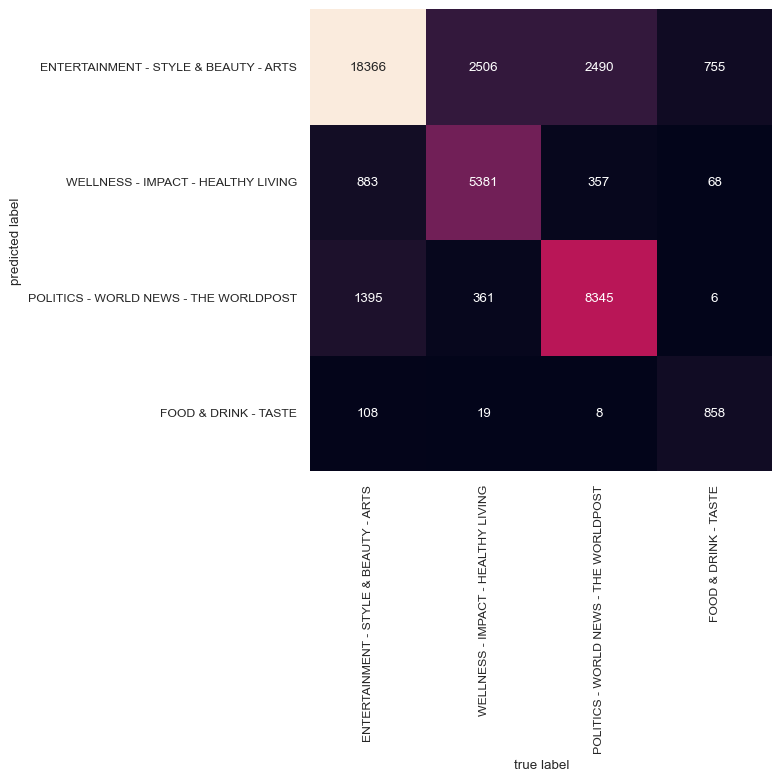

In [1480]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(threshold=1000)

print('Overall F1 Score: {:.2%}'.format(f1_score_result))

plt.rcParams.update({'font.size': 8, 'figure.figsize': [6, 6]})
sns.set_theme(font_scale=0.8)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=dominant_categories, yticklabels=dominant_categories)
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

In [1487]:
headline = input('Enter a headline')
pred = model.predict([headline])
print('The headline "' + headline + '" is in the category ' + pred[0])

The headline "Chef Gordon Teaches about Cooking" is in the category FOOD & DRINK - TASTE
